# 1 Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from imblearn.metrics import classification_report_imbalanced

# 2 Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
"loan_amnt", "int_rate", "installment", "home_ownership",
"annual_inc", "verification_status", "issue_d", "loan_status",
"pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
"open_acc", "pub_rec", "revol_bal", "total_acc",
"initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
"total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
"recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
"collections_12_mths_ex_med", "policy_code", "application_type","acc_now_delinq",
"tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
"open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
"il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
"all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
"inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
"bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
"mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl","mort_acc",
"mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd","num_actv_bc_tl",
"num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
"num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
"num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
"num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75","pub_rec_bankruptcies",
"tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
"total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('../Resources/LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()


,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# 3 Split the Data into Training and Testing

In [5]:

# Create our features
X = pd.get_dummies(df.drop('loan_status', axis=1))

# Create our target
y = df['loan_status']


In [6]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [7]:
y.head()

0    low_risk
1    low_risk
2    low_risk
3    low_risk
4    low_risk
Name: loan_status, dtype: object

In [8]:
type(y)

pandas.core.series.Series

In [9]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [10]:

# Create X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=1, stratify=y)
X_train.shape

(51612, 95)

# Oversampling

In this section, I will compare two oversampling algorithms to determine which algorithm results in the best performance. O will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. Steps i took for each algorithm:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: A random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [11]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_sampled, y_sampled = ros.fit_sample(X_train, y_train)
Counter(y_sampled)

Counter({'low_risk': 51352, 'high_risk': 51352})

In [12]:

# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_sampled, y_sampled)

LogisticRegression(random_state=1)

In [13]:

# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)
ba_score=balanced_accuracy_score(y_test, y_pred)

Confusion Matrix


,Positive,Negative
High_Risk,51,36
Low_Risk,5422,11696



Balanced Accuracy Score:0.6347321432168598

Classification Report Imbalanced
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.59      0.68      0.02      0.63      0.40        87
   low_risk       1.00      0.68      0.59      0.81      0.63      0.40     17118

avg / total       0.99      0.68      0.59      0.81      0.63      0.40     17205



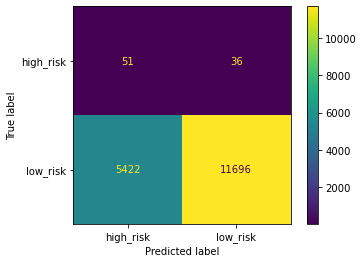

In [14]:

# Display the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["High_Risk", "Low_Risk"], columns=["Positive", "Negative"]
)
print("Confusion Matrix")
display(cm_df)

print(f"\nBalanced Accuracy Score:{ba_score}")

report=classification_report_imbalanced(y_test, y_pred)
print(f"\nClassification Report Imbalanced")
print(report)


plot_confusion_matrix(model, X_test, y_test)
plt.show()

### SMOTE Oversampling

In [15]:

# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter


X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'low_risk': 51352, 'high_risk': 51352})

In [16]:

# Train the Logistic Regression model using the resampled data
remodel = LogisticRegression(solver='lbfgs', random_state=1)
remodel.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [17]:

# Calculated the balanced accuracy score
y_pred = remodel.predict(X_test)
ba_score2=balanced_accuracy_score(y_test, y_pred)

Confusion Matrix


,Positive,Negative
High_Risk,58,29
Low_Risk,6369,10749



Balanced Accuracy Score:0.6473010865755344

Classification Report Imbalanced
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.67      0.63      0.02      0.65      0.42        87
   low_risk       1.00      0.63      0.67      0.77      0.65      0.42     17118

avg / total       0.99      0.63      0.67      0.77      0.65      0.42     17205



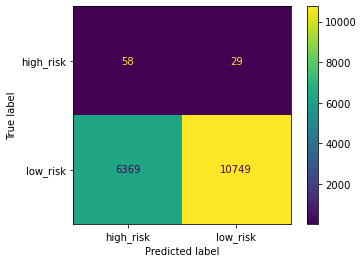

In [18]:
# Display the confusion matrix

cm2 = confusion_matrix(y_test, y_pred)
cm_df2 = pd.DataFrame(
    cm2, index=["High_Risk", "Low_Risk"], columns=["Positive", "Negative"]
)
print("Confusion Matrix")
display(cm_df2)

print(f"\nBalanced Accuracy Score:{ba_score2}")

report2=classification_report_imbalanced(y_test, y_pred)
print(f"\nClassification Report Imbalanced")
print(report2)


plot_confusion_matrix(remodel, X_test, y_test)
plt.show()

# Undersampling

In this section, I will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. I will undersample the data using the Cluster Centroids algorithm and steps follow:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: A random state of 1 for each sampling algorithm to ensure consistency between tests

In [19]:
# Resample the data using the ClusterCentroids resampler
# YOUR CODE HERE
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 260, 'low_risk': 260})

In [20]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE

model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
intercept_scaling=1, max_iter=100, multi_class='auto',
n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
tol=0.0001, verbose=0, warm_start=False)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [21]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

y_pred_undersample = model.predict(X_test)
ba_score3=balanced_accuracy_score(y_test, y_pred_undersample)

Confusion Matrix


,Positive,Negative
High_Risk,54,33
Low_Risk,9951,7167



Balanced Accuracy Score:0.519685872100753

Classification Report Imbalanced
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.62      0.42      0.01      0.51      0.27        87
   low_risk       1.00      0.42      0.62      0.59      0.51      0.25     17118

avg / total       0.99      0.42      0.62      0.59      0.51      0.25     17205



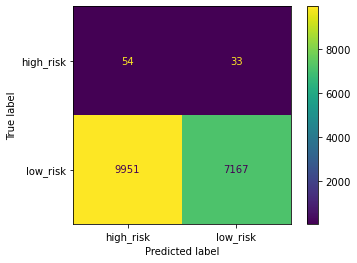

In [22]:
# Display the confusion matrix
# YOUR CODE HERE

cm3 = confusion_matrix(y_test, y_pred_undersample)
cm_df3 = pd.DataFrame(
    cm3, index=["High_Risk", "Low_Risk"], columns=["Positive", "Negative"]
)
print("Confusion Matrix")
display(cm_df3)

print(f"\nBalanced Accuracy Score:{ba_score3}")

# Print the imbalanced classification report
# YOUR CODE HERE
print("\nClassification Report Imbalanced")
print(classification_report_imbalanced(y_test, y_pred_undersample))

plot_confusion_matrix(model, X_test, y_test)
plt.show()

# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [23]:
# Resample the training data with SMOTEENN
# YOUR CODE HERE
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=1,  sampling_strategy=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 51351, 'low_risk': 46389})

In [24]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE

model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
intercept_scaling=1, max_iter=100, multi_class='auto',
n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
tol=0.0001, verbose=0, warm_start=False)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [25]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

y_pred_over_under = model.predict(X_test)
ba_score4=balanced_accuracy_score(y_test, y_pred_over_under)

Confusion Matrix


,Positive,Negative
High_Risk,58,29
Low_Risk,7301,9817



Balanced Accuracy Score:0.6200782801729174

Classification Report Imbalanced:
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.67      0.57      0.02      0.62      0.39        87
   low_risk       1.00      0.57      0.67      0.73      0.62      0.38     17118

avg / total       0.99      0.57      0.67      0.72      0.62      0.38     17205



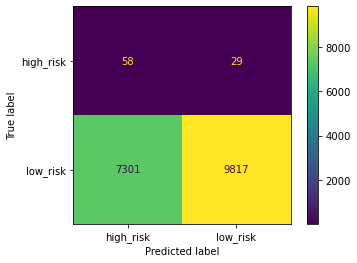

In [26]:
# Display the confusion matrix
# YOUR CODE HERE

cm4 = confusion_matrix(y_test,  y_pred_over_under )
cm_df4 = pd.DataFrame(
    cm4, index=["High_Risk", "Low_Risk"], columns=["Positive", "Negative"]
)
print("Confusion Matrix")
display(cm_df4)

print(f"\nBalanced Accuracy Score:{ba_score4}")

# Print the imbalanced classification report
# YOUR CODE HERE
print("\nClassification Report Imbalanced:")
print(classification_report_imbalanced(y_test, y_pred_over_under))

plot_confusion_matrix(model, X_test, y_test)
plt.show()